# Data Sample Analysis

## Problem: Car insurance cold calls
original dataset: https://www.kaggle.com/kondla/carinsurance

## Description
This is a dataset from one bank in the United States. Besides usual services, this bank also provides car insurance services. The bank organizes regular campaigns to attract new clients. The bank has potential customers’ data, and bank’s employees call them for advertising available car insurance options. We are provided with general information about clients (age, job, etc.) as well as more specific information about the current insurance sell campaign (communication, last contact day) and previous campaigns (attributes like previous attempts, outcome).
You have data about 4000 customers who were contacted during the last campaign and for whom the results of campaign (did the customer buy insurance or not) are known.

## Classification Task
The task is to predict for the customers who were contacted during the current campaign, whether they will buy car insurance or not.

## Sample request
**Sample size**
- ask for small but representative data (1 week, 1 day, 1 hour)
- ask for reasonable sample size. If date for 1 day is 1Tb, then take a smaller part

**Data description and data schema**

**Data format**
- ask to upload data in a format similar to one you supposed to have for full dataset
- ask to upload data in a format similar to one you supposed to have in production (unfortunately, close to impossible)

**Data transfer method**
- discuss data transfer method in advance
- make sure that the security service at the customer’s side agreed on the transfer method
- it is good idea to test transfer method you supposed to use for future data exchange

**Sensitive data**
- if possible do not ask for it =)
- advice customer how to perform data depersonalization and obfuscation
- finance (costs, revenue etc) data can be normalized

**Data processing**
- ask for raw data without unnecessary processing, filtration or aggregation
- if some data cannot be unloaded raw - processing process needs to be clarified

**Data sources and variables**

target variable (variables) 
- make sure it will be in sample
- make sure there will be no processing over target function performed before data transferred
- if you work with unbalanced classification problem, ask in advance for certain number of events from minor class

variables
- ask what data sources are the most relevant to the problem from clients poin of view
- if it is too complicated to upload data from all sources, it is better to start earlier with a reaonable subset

external data
- ask if client uses some external data (weather, exchange rates, competitor information)
- if client uses some external data (even publicly available) - you might be interested in uploading it from client

## Sample analysis plan

**Data scheme review**
- check if data matches provided scheme
- is it possible to join all data parts together?
- is there any collusion in IDs?
- can you distinguish zero values from NA values?

**Target function analysis**

**Variables analysis**
- variable types
- distributions
- ranges and statistics (constant values, unique values)
- unexpected values
- main dependencies (material balance etc.)

**Corellation analysis**

**Data visualization**
- target visualization
- pairplots
- distributions by classes

**Baseline model training**
- use simple models, like linear regression with strong regularization
- use leave-one-out CV strategy

## Analysis

In [84]:
from IPython.display import Image

In [85]:
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, model_selection, ensemble

In [86]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py

py.init_notebook_mode(connected=True)

In [87]:
matplotlib.pyplot.style.use('ggplot')
%matplotlib inline

## Data scheme review

In [10]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [88]:
data = pd.read_csv('carInsurance_train.csv')

In [89]:
data.shape

(4000, 19)

**Data preview**

In [90]:
data.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


**Feature overview**

In [70]:
Image("/content/drive/MyDrive/HS_IML_2022/code/car_features_overview.jpeg")

FileNotFoundError: No such file or directory: '/content/drive/MyDrive/HS_IML_2022/code/car_features_overview.jpeg'

FileNotFoundError: No such file or directory: '/content/drive/MyDrive/HS_IML_2022/code/car_features_overview.jpeg'

<IPython.core.display.Image object>

**Some descriptive statistic for numeric variable**

In [91]:
data.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


**Some descriptive statistic for categorical variable**

In [92]:
data.describe(include = [object])

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,3098,4000,958,4000,4000
unique,11,3,3,2,12,3,3777,3764
top,management,married,secondary,cellular,may,failure,17:11:04,10:22:30
freq,893,2304,1988,2831,1049,437,3,3


**Missing values**

In [93]:
data.isnull().sum()

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

## High-level tools

### Pandas Profiling

In [74]:
!pip install -U pandas-profiling[notebook]

In [94]:
from pandas_profiling import ProfileReport

In [95]:
profile = ProfileReport(data[['Age', 'Job', 'Education']]) #,explorative=True)
profile.to_file(output_file="car_insurance_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Facests visualization

In [77]:
!pip install facets_overview

In [97]:
import base64
import facets_overview

from IPython.display import display, HTML
# from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

In [79]:
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'car_insurance_data', 'table': data}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

NameError: name 'GenericFeatureStatisticsGenerator' is not defined

In [80]:
OUTPUT_FILE_PATH = '/content/drive/MyDrive/HS_IML_2022/code/car_insurance_facets_overview.html'

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""

html = HTML_TEMPLATE.format(protostr=protostr)

# to display
# display(HTML(html))

# to save
with open(OUTPUT_FILE_PATH, "wb") as f:
    f.write(html.encode('utf-8'))

NameError: name 'protostr' is not defined

## Target function analysis

In [98]:
data.CarInsurance.value_counts()

0    2396
1    1604
Name: CarInsurance, dtype: int64

In [99]:
fig = go.Figure([go.Bar(x = ['no', 'yes'], y = data.CarInsurance.value_counts())])
fig.show()

In [100]:
target_corr = data.corr()['CarInsurance']

fig = go.Figure([go.Bar(y = target_corr, x = target_corr.index, marker_color = 'red')])

fig.update_layout(xaxis_title = "Features", yaxis_title = "Correlation",
    yaxis = dict(
        range=(-1, 1),
        showticklabels=True
    ))
fig.show()

## Variable analysis

### Feature distribution analisys

In [101]:
for feature in ['Age', 'Balance', 'NoOfContacts', 'DaysPassed', 'PrevAttempts', 'Job']:

    fig = go.Figure()
    fig.add_trace(go.Histogram(x = data[data.CarInsurance == 1][feature], 
                 marker_color = 'green', opacity = 0.6, nbinsx = 10,  name = 'Yes', histnorm = 'probability'))

    fig.add_trace(go.Histogram(x = data[data.CarInsurance == 0][feature],
                 marker_color = 'red', opacity = 0.6,nbinsx = 10, name = 'No', histnorm = 'probability'))

    fig.update_layout(
        legend = dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        ),
        xaxis_title = feature,
        yaxis_title = "Share"
    )
    fig.show()

### Pair plot for expert selected numeric variables

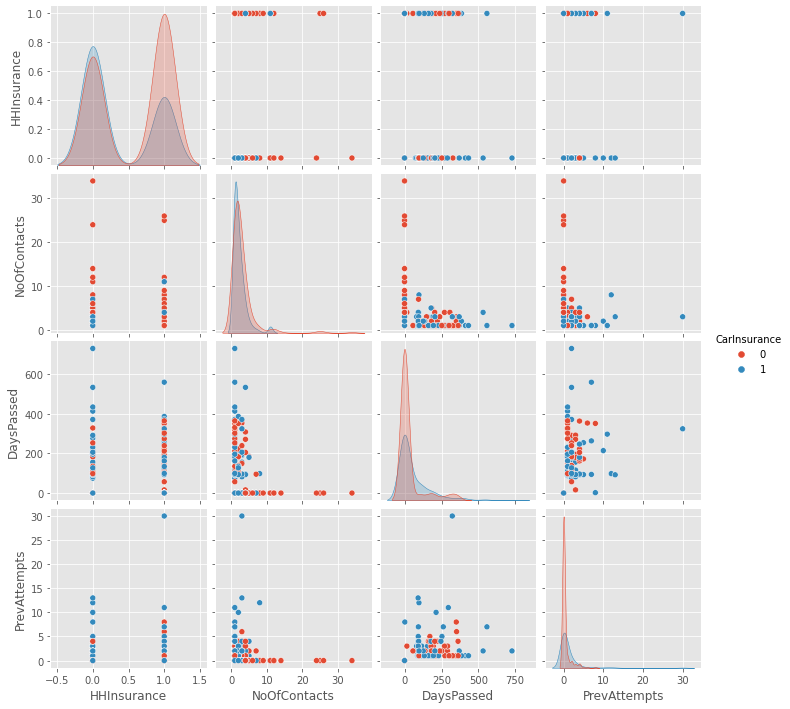

In [102]:
sns.pairplot(data.loc[:500, ['CarInsurance', 'HHInsurance', 'NoOfContacts', 'DaysPassed', 'PrevAttempts']],
            hue = 'CarInsurance')

### Correlation analysis

In [103]:
correlation_matrix = data.corr()
correlation_matrix = correlation_matrix.drop(['Id'], axis=1).drop(['Id'], axis=0)

fig = go.Figure(data=go.Heatmap(
                   z = correlation_matrix,
                   x = correlation_matrix.columns,
                   y = correlation_matrix.index,
                   hoverongaps = False,
                   xgap = 1,
                   ygap = 1,
                   zmin = -1,
                   zmax = 1,
    colorscale = 'rdbu_r'
))

fig.update_xaxes(side="top")
fig.update_layout(xaxis_title = "Features", yaxis_title = "Features")
fig.show()

## Baseline model training

### Constant Baseline

In [104]:
const_score = metrics.accuracy_score(data.CarInsurance, [0]*data.shape[0])
const_score

0.599

### Numerical features baseline

In [105]:
num_data = data.select_dtypes(include = [np.number])

In [106]:
num_data.isnull().sum()

Id                0
Age               0
Default           0
Balance           0
HHInsurance       0
CarLoan           0
LastContactDay    0
NoOfContacts      0
DaysPassed        0
PrevAttempts      0
CarInsurance      0
dtype: int64

In [107]:
model = ensemble.RandomForestClassifier(random_state = 128)

In [108]:
numeric_baseline_score = model_selection.cross_val_score(
    model,
    X = num_data[['Age', 'Default', 'Balance', 'HHInsurance', 'CarLoan', 
             'LastContactDay', 'NoOfContacts', 'DaysPassed', 'PrevAttempts']],
    y = num_data.CarInsurance,
    cv = 5,
    scoring = 'accuracy'
    )

In [109]:
numeric_baseline_score.mean(), numeric_baseline_score.std()

(0.6725, 0.015268431484602461)

### Baseline with simple feature engineering

In [110]:
data_copy = data.copy()
data_copy.drop(['CarInsurance', 'Id', 'CallEnd', 'CallStart'], axis = 1, inplace = True)
print(data_copy.shape)

(4000, 15)


In [111]:
data_copy.isnull().sum()

Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
dtype: int64

In [112]:
# Fill missing outcome as not in previous campaign
print(data_copy['Outcome'].value_counts())
data_copy.loc[data_copy['DaysPassed'] == -1, 'Outcome'] = 'NoPrev'
print(data_copy.Outcome.value_counts())

failure    437
success    326
other      195
Name: Outcome, dtype: int64
NoPrev     3042
failure     437
success     326
other       195
Name: Outcome, dtype: int64


In [113]:
# Outcome digitization
data_copy['Outcome'] = data_copy['Outcome'].replace({'failure' : -1, 'success' : 2, 'other' : 0, 'NoPrev' : 1})
print(data_copy['Outcome'].value_counts())

 1    3042
-1     437
 2     326
 0     195
Name: Outcome, dtype: int64


In [114]:
# Fill missing communication with none 
print(data_copy['Communication'].value_counts())
data_copy['Communication'].fillna('none', inplace = True)
print(data_copy['Communication'].value_counts())

cellular     2831
telephone     267
Name: Communication, dtype: int64
cellular     2831
none          902
telephone     267
Name: Communication, dtype: int64


In [115]:
# Communication digitization
data_copy['Communication'] = data_copy['Communication'].replace({'none':0,'telephone':1,'cellular':2})
print(data_copy['Communication'].value_counts())

2    2831
0     902
1     267
Name: Communication, dtype: int64


In [116]:
# Fill missing education with the most common one
most_common_education = data_copy['Education'].value_counts().idxmax()
print(most_common_education)
data_copy['Education'].fillna(most_common_education, inplace = True)
print(data_copy['Education'].value_counts())

secondary
secondary    2157
tertiary     1282
primary       561
Name: Education, dtype: int64


In [117]:
# Education digitization
data_copy['Education'] = data_copy['Education'].replace({'None' : 0, 'primary' : 1, 'secondary' : 2, 'tertiary' : 3})
print(data_copy['Education'].value_counts())

2    2157
3    1282
1     561
Name: Education, dtype: int64


In [118]:
# Marital digitization
data_copy['Marital'] = data_copy['Marital'].replace({'married' : -1, 'single' : 0,'divorced' : 1})
print(data_copy['Marital'].value_counts())

-1    2304
 0    1213
 1     483
Name: Marital, dtype: int64


In [119]:
# Fill missing job with none
data_copy['Job'].fillna('none', inplace = True)
print(data_copy['Job'].value_counts())

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
none              19
Name: Job, dtype: int64


In [120]:
# LastContactMonth digitization
LastContactMonth_dummies = pd.get_dummies(data_copy.LastContactMonth , prefix = 'month')
data_copy = pd.concat([data_copy, LastContactMonth_dummies], axis = 1)

In [121]:
# Job digitization
Job_dummies = pd.get_dummies(data_copy.Job , prefix = 'job')
data_copy = pd.concat([data_copy, Job_dummies], axis = 1)

In [122]:
data_copy.drop(columns = ['LastContactMonth', 'Job'], inplace = True)

In [123]:
data_copy.isnull().sum().sum()

0

In [57]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                4000 non-null   int64
 1   Marital            4000 non-null   int64
 2   Education          4000 non-null   int64
 3   Default            4000 non-null   int64
 4   Balance            4000 non-null   int64
 5   HHInsurance        4000 non-null   int64
 6   CarLoan            4000 non-null   int64
 7   Communication      4000 non-null   int64
 8   LastContactDay     4000 non-null   int64
 9   NoOfContacts       4000 non-null   int64
 10  DaysPassed         4000 non-null   int64
 11  PrevAttempts       4000 non-null   int64
 12  Outcome            4000 non-null   int64
 13  month_apr          4000 non-null   uint8
 14  month_aug          4000 non-null   uint8
 15  month_dec          4000 non-null   uint8
 16  month_feb          4000 non-null   uint8
 17  month_jan     

In [124]:
data_copy.head()

,Age,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,NoOfContacts,...,job_entrepreneur,job_housemaid,job_management,job_none,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,32,0,3,0,1218,1,0,1,28,2,...,0,0,1,0,0,0,0,0,0,0
1,32,-1,1,0,1156,1,0,0,26,5,...,0,0,0,0,0,0,0,0,0,0
2,29,0,3,0,637,1,0,2,3,1,...,0,0,1,0,0,0,0,0,0,0
3,25,0,1,0,373,1,0,2,11,2,...,0,0,0,0,0,0,0,1,0,0
4,30,-1,3,0,2694,0,0,2,3,1,...,0,0,1,0,0,0,0,0,0,0


In [125]:
simple_fe_baseline_score = model_selection.cross_val_score(
    model,
    X = data_copy,
    y = data.CarInsurance,
    cv = 5,
    scoring = 'accuracy'
    )

In [126]:
simple_fe_baseline_score.mean(), simple_fe_baseline_score.std()

(0.727, 0.012057155551787524)

## Result of the analysis and report

**Executive summary**
- what have been done (we have conducted a preliminary data analysis)
- what does report contain (this report contains information about preliminary data analysis, intermediate results, and data-related questions)
- main conclusions in short form (is data format suitable for the further analysis? Are you willing to receive all data in the same format? is something important missing?)

**General data sample infomation**
- data sample souce, version
- data visualization results
- statistic analysis result
- correlation analysis result
- I do NOT recommend include any modeling results, but it is possible

**Questions with examples**

**Major risks if exists**

**Main conclusions**
- is data complete?
- is data structure clear?
- does data meets key expectations and initial prerequisites of the project?
- any issues with the target?
- any unexpected results in the statistical analysis?
- any unexpected things in the correlation analysis?
- any potential problems with future modeling?